Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
!pip install kmodes



In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from kmodes.kmodes import KModes
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


In [4]:
# helper function for models evaluation adn performance comparison
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, classification_report

def evaluate_model(model,model_Name, x_val, y_val):
    # Evaluate the model
    y_pred_probs = model.predict(x_val)
    # Convert probabilities to binary class labels based on a threshold (e.g., 0.5)
    y_pred_classes = (y_pred_probs > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred_classes)
    precision = precision_score(y_val, y_pred_classes, average='micro')
    recall = recall_score(y_val, y_pred_classes, average='micro')
    f1 = f1_score(y_val, y_pred_classes, average='micro')
    # Create DataFrame to store metrics
    metrics_df = pd.DataFrame({
        'Model': [model_Name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

    return metrics_df


Reading the data

In [5]:
file_path = '/content/drive/My Drive/cardio_train.csv'
df = pd.read_csv(file_path, sep=';', encoding='utf-8')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Checking for missing values

In [7]:
print(df.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [8]:
#drop id
df = df.drop('id', axis=1)

# print(df)

**Demographics Results**



In [ ]:
class_counts = df['cardio'].value_counts()
class_percent = df['cardio'].value_counts(normalize=True) * 100

print(pd.DataFrame({
    "Count": class_counts,
    "Percentage": class_percent.round(2)
}))


        Count  Percentage
cardio                   
0       35021       50.03
1       34979       49.97


In [ ]:
df['age_years'] = (df['age'] / 365).round(1)
print("Mean age:", round(df['age_years'].mean(), 2))
print("SD age:", round(df['age_years'].std(), 2))
print("Min age:", df['age_years'].min())
print("Max age:", df['age_years'].max())


Mean age: 53.34
SD age: 6.76
Min age: 29.6
Max age: 65.0


In [ ]:
df['gender'] = df['gender'].map({1: "Female", 2: "Male"})
gender_counts = df['gender'].value_counts()
gender_percent = df['gender'].value_counts(normalize=True) * 100

print(pd.DataFrame({
    "Count": gender_counts,
    "Percentage": gender_percent.round(2)
}))


        Count  Percentage
gender                   
Female  45530       65.04
Male    24470       34.96


In [ ]:
df['BMI'] = df['weight'] / (df['height']/100)**2

print("Mean BMI:", round(df['BMI'].mean(), 2))
print("SD BMI:", round(df['BMI'].std(), 2))
print("Min BMI:", round(df['BMI'].min(), 2))
print("Max BMI:", round(df['BMI'].max(), 2))


Mean BMI: 27.56
SD BMI: 6.09
Min BMI: 3.47
Max BMI: 298.67


In [ ]:
print("Mean Systolic BP:", round(df['ap_hi'].mean(), 2))
print("SD Systolic BP:", round(df['ap_hi'].std(), 2))


Mean Systolic BP: 128.82
SD Systolic BP: 154.01


In [7]:
import pandas as pd
import numpy as np

# ---------------------------
# Helper functions
# ---------------------------

def print_counts_percent(series, index_map=None):
    counts = series.value_counts(dropna=False)
    perc = series.value_counts(normalize=True, dropna=False) * 100
    table = pd.DataFrame({"Count": counts.astype(int), "Percent": perc.round(2)})
    if index_map:
        table.index = [index_map.get(i, i) for i in table.index]
    print(table)
    print()
    return table

def numeric_summary(series):
    s = series.dropna().astype(float)
    mean = s.mean()
    std = s.std()
    med = s.median()
    mn = s.min()
    mx = s.max()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    print(f"Mean ± SD: {mean:.2f} ± {std:.2f}")
    print(f"Median:    {med:.2f}")
    print(f"Range:     {mn} – {mx}")
    print(f"IQR:       {iqr:.2f} (Q1={q1:.2f}, Q3={q3:.2f})")
    print()
    return


# ---------------------------
# Columns to IGNORE
# ---------------------------

ignore_cols = ["id", "age", "gender", "BMI", "ap_hi", "cardio"]

# ---------------------------
# Columns to SUMMARIZE
# ---------------------------

numeric_cols = ["height", "weight", "ap_lo"]
categorical_cols = ["cholesterol", "gluc", "smoke", "alco", "active"]

# Maps for categorical variables
chol_map = {1: "Normal (1)", 2: "Above normal (2)", 3: "High (3)"}
gluc_map = {1: "Normal (1)", 2: "Above normal (2)", 3: "High (3)"}
bin_map  = {0: "No (0)", 1: "Yes (1)"}   # smoke, alco, active


print("===== DEMOGRAPHIC SUMMARY (Filtered Columns) =====\n")

# ---------------------------
# NUMERIC COLUMNS
# ---------------------------
for col in numeric_cols:
    if col in df.columns:
        print(f"--- {col} ---")
        numeric_summary(df[col])

# ---------------------------
# CATEGORICAL COLUMNS
# ---------------------------
for col in categorical_cols:
    if col not in df.columns:
        continue

    print(f"--- {col} ---")

    if col == "cholesterol":
        mapping = chol_map
    elif col == "gluc":
        mapping = gluc_map
    else:
        mapping = bin_map

    print_counts_percent(df[col], index_map=mapping)


===== DEMOGRAPHIC SUMMARY (Filtered Columns) =====

--- height ---
Mean ± SD: 164.36 ± 8.21
Median:    165.00
Range:     55.0 – 250.0
IQR:       11.00 (Q1=159.00, Q3=170.00)

--- weight ---
Mean ± SD: 74.21 ± 14.40
Median:    72.00
Range:     10.0 – 200.0
IQR:       17.00 (Q1=65.00, Q3=82.00)

--- ap_lo ---
Mean ± SD: 96.63 ± 188.47
Median:    80.00
Range:     -70.0 – 11000.0
IQR:       10.00 (Q1=80.00, Q3=90.00)

--- cholesterol ---
                  Count  Percent
Normal (1)        52385    74.84
Above normal (2)   9549    13.64
High (3)           8066    11.52

--- gluc ---
                  Count  Percent
Normal (1)        59479    84.97
High (3)           5331     7.62
Above normal (2)   5190     7.41

--- smoke ---
         Count  Percent
No (0)   63831    91.19
Yes (1)   6169     8.81

--- alco ---
         Count  Percent
No (0)   66236    94.62
Yes (1)   3764     5.38

--- active ---
         Count  Percent
Yes (1)  56261    80.37
No (0)   13739    19.63



# **Removing Outliers:**

It is important to remove outliers to improve the performance of our prediction models. We have removed outliers that fall outside the range of 2.5% to 97.5% in all instances of ap_hi, ap_lo, weight, and height features. This process has decreased the entries in the data set from 70,000 to 60,142 records.

<Axes: >

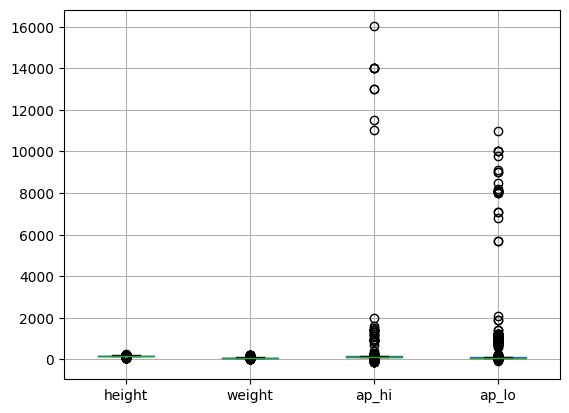

In [9]:
 #plot numerical vlaues
 numeric_data=df[["height","weight","ap_hi","ap_lo"]]
 numeric_data.boxplot()

In [10]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
len(df)

60142

How many cases where diastolic pressure is higher than systolic?

In [11]:
df[df['ap_lo']> df['ap_hi']].shape[0]

0

<Axes: >

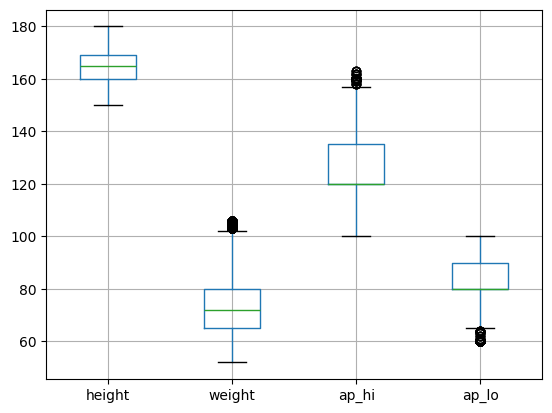

In [12]:
 #plot numerical vlaues
 num_data=df[["height","weight","ap_hi","ap_lo"]]
 num_data.boxplot()

In [13]:
#after removing outliers
df.describe()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,19468.719979,1.347311,164.554854,73.426805,125.770526,81.046307,1.350953,1.220229,0.085631,0.051877,0.803648,0.488228
std,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,10798.000000,1.000000,150.000000,52.000000,100.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17677.250000,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19705.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21321.000000,2.000000,169.000000,80.000000,135.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,180.000000,106.000000,163.000000,100.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Transformation:
Converting age from days to years

In [14]:
df['age'] = (df['age'] / 365).round().astype('int')

print(df.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
4   48       1     156    56.0    100     60            1     1      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


Categorizing features

In [15]:
# # Define the bin edges and labels
age_edges = [30, 35, 40, 45, 50, 55, 60, 65]
age_labels = [0, 1, 2, 3, 4, 5, 6]

#  bin in  5 years span
df['age_group'] = pd.cut(df['age'], bins=7, labels=range(7), include_lowest=True,right=True)
df.head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3


**Attribute Combination**

It is important to combine some attributes into more meaningful ones. For example, using Body Mass Index (BMI) instead of the features weight and height individually, is more useful. Therefore, we have added Body Mass Index (BMI) and Mean Arterial Pressure (MAP) to the data.

In [16]:
df['bmi'] = df['weight']/((df['height']/100)**2)
df.head()

bmiMin = int(df['bmi'].min())
bmiMax = int(df['bmi'].max())

print(bmiMin, bmiMax)

df['bmi'] = pd.cut(df['bmi'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()


df["bmi"].value_counts(normalize=True)

16 46


,proportion
bmi,
1,0.461325
2,0.330202
3,0.133068
0,0.038193
4,0.033554
5,0.003658


In [17]:
df['map'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

mapMin = int(df['map'].min())
mapMax = int(df['map'].max())

print(mapMin, mapMax)

df['map'] = pd.cut(df['map'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()

73 121


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,50,2,168,62.0,110,80,1,1,0,0,1,0,3,1,2
1,55,1,156,85.0,140,90,3,1,0,0,1,1,4,3,4
2,52,1,165,64.0,130,70,3,1,0,0,0,1,4,1,2
3,48,2,169,82.0,150,100,1,1,0,0,1,1,3,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,3,1,0


Print Null rows

In [18]:
null_rows = df[df.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio, age_group, bmi, map]
Index: []


**Drop features**
We only need categorical data

In [19]:
df_og=df

df=df.drop(['height','weight','ap_hi','ap_lo','age'],axis=1)

df.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,2,1,1,0,0,1,0,3,1,2
1,1,3,1,0,0,1,1,4,3,4
2,1,3,1,0,0,0,1,4,1,2
3,2,1,1,0,0,1,1,3,2,5
4,1,1,1,0,0,0,0,3,1,0


**Label Encoder**

In [20]:
le = preprocessing.LabelEncoder()
df = df.apply(le.fit_transform)
df.describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,0.347311,0.350953,0.220229,0.085631,0.051877,0.803648,0.488228,4.042233,1.673440,2.359449
std,0.476120,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866,1.377070,0.898707,1.186906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,2.000000,2.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,3.000000
max,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


# **Clustering**

Clustering is used in machine learning to find similarities between data by grouping.  The most common technique for clustering is K-means. However, it is not effective for categorical data. K-means uses a Euclidean distance measure differences between data points. For our data, we have used **K-modes** which is the appropriate clustering algorithm for categorical data because it uses mode-based distance between the categories, so it is more suitable for categorical data. To find the optimal number of clusters, we have utilized the **elbow curve method**.

In [21]:
cost = []
num_clusters = range(1,6) # 1 to 5
for i in list(num_clusters):
    kmode = KModes(n_clusters=i, init = "Huang", n_init = 5, verbose=0,random_state=1)
    kmode.fit_predict(df)
    cost.append(kmode.cost_)


**Clusters graph**

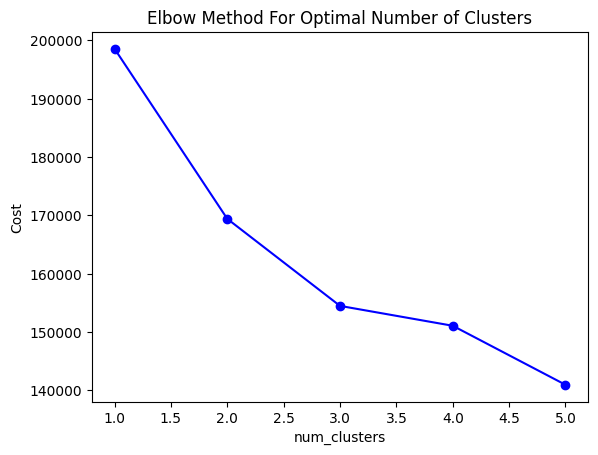

In [22]:
plt.plot(num_clusters, cost, 'bo-')
plt.xlabel('num_clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

Building KModes model

In [23]:
km = KModes(n_clusters=2, init = "Huang", n_init = 5,random_state=1)
clusters = km.fit_predict(df)
clusters

array([0, 1, 0, ..., 0, 1, 0], dtype=uint16)

Adding clusters column in DF

In [24]:
df.insert(0,"clusters",clusters,True)

df.head()

,clusters,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,0,1,0,0,0,0,1,0,3,1,2
1,1,0,2,0,0,0,1,1,4,3,4
2,0,0,2,0,0,0,0,1,4,1,2
3,1,1,0,0,0,0,1,1,3,2,5
4,0,0,0,0,0,0,0,0,3,1,0


# **Correlation Matrix**

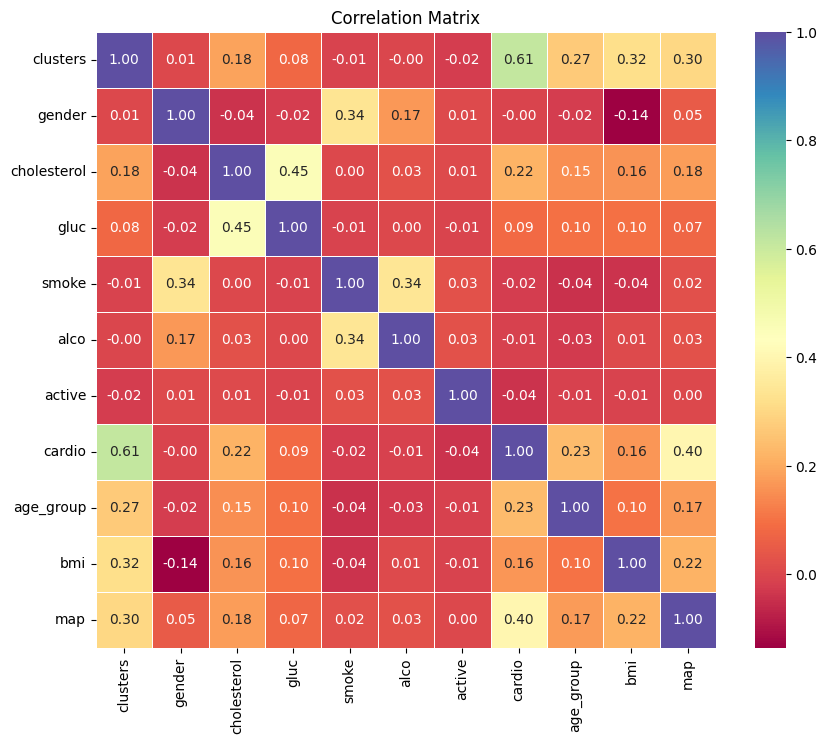

In [25]:
# Set up figure
plt.figure(figsize=(10, 8))

# Draw correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)

# Show the figure
plt.title('Correlation Matrix')
plt.show()

'gender' has a correlation of 0 to our target 'cardio', and 'smoke' has a correlation of '0.01'.
We will remove those features to increase performance.

Distribution of cardio in clusters

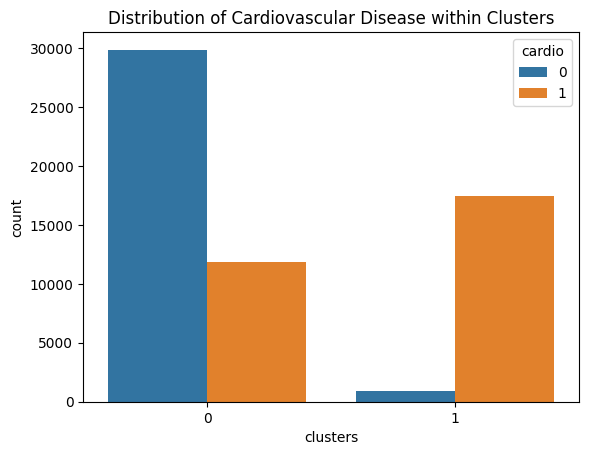

In [26]:
sns.countplot(x='clusters', hue='cardio', data=df)
plt.title('Distribution of Cardiovascular Disease within Clusters')
plt.show()




# **Split Data**

Training set: 80%

Test set: 20%

According to the correlation table, gender has 0 correlation with our target. Moreover, ‘alco’ has 0.01 correlation. Therefore, we dropped those two features and saw an increase in the performance of our models.

In [27]:
x = df.drop(['cardio','gender','alco'], axis=1)
y = df['cardio']

x.head()

,clusters,cholesterol,gluc,smoke,active,age_group,bmi,map
0,0,0,0,0,1,3,1,2
1,1,2,0,0,1,4,3,4
2,0,2,0,0,0,4,1,2
3,1,0,0,0,1,3,2,5
4,0,0,0,0,0,3,1,0


In [28]:
# 1️⃣ One-hot encode full dataset for ANN
x_encoded = pd.get_dummies(x)

# 2️⃣ Global train-test split — used by ALL MODELS
x_train, x_test, y_train, y_test = train_test_split(
    x_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Unified shapes:")
print(len(y_test))     # ✅ 12029
print(x_test.shape)


Unified shapes:
12029
(12029, 8)


In [ ]:
print(f"Number of training samples: {len(x_train)}")
print(f"Number of testing samples: {len(x_test)}")
print(f"Number of training samples: {len(y_train)}")
print(f"Number of testing samples: {len(y_test)}")

Number of training samples: 48113
Number of testing samples: 12029
Number of training samples: 48113
Number of testing samples: 12029


In [ ]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48113 entries, 16547 to 47227
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clusters     48113 non-null  uint16
 1   cholesterol  48113 non-null  int64 
 2   gluc         48113 non-null  int64 
 3   smoke        48113 non-null  int64 
 4   active       48113 non-null  int64 
 5   age_group    48113 non-null  int64 
 6   bmi          48113 non-null  int64 
 7   map          48113 non-null  int64 
dtypes: int64(7), uint16(1)
memory usage: 3.0 MB


# **No data leakage proof**

In [ ]:

print("Train mean:", x_train.mean().values)
print("Full mean:", x.mean().values)


Train mean: [0.3066323  0.34811797 0.21900526 0.0856941  0.80421092 4.04291979
 1.67098289 2.36372706]
Full mean: [0.30604237 0.35095275 0.22022879 0.08563067 0.80364803 4.04223338
 1.67343953 2.3594493 ]


In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# 1. Leakage Verification Function
# ============================================================
def verify_no_leakage(preprocessors, x_train, x_full):
    """
    preprocessors: dict of name -> fitted object or metadata dict
    x_train: training feature dataframe
    x_full: original full feature dataframe
    """
    report = {}
    print("========== DATA LEAKAGE VERIFICATION ==========\n")

    # --------------------------------------------------------
    # Numeric sanity check: Train mean vs Full mean
    # --------------------------------------------------------
    train_mean = x_train.mean(axis=0).values
    full_mean  = x_full.mean(axis=0).values

    print("📌 Quick numeric check (first 8 features):")
    print("Train mean:", np.round(train_mean[:8], 6))
    print("Full  mean:", np.round(full_mean[:8], 6))

    means_different = np.any(~np.isclose(train_mean, full_mean))
    if means_different:
        print("\n✔ Train and full means DIFFER → Normal → NO LEAKAGE.")
    else:
        print("\n⚠ Train and full means IDENTICAL → Suspicious (possible leakage).")

    print("\n--------------------------------------------------------\n")

    # --------------------------------------------------------
    # Check for Scaler objects (if any)
    # --------------------------------------------------------
    for name, obj in preprocessors.items():
        if hasattr(obj, "mean_"):  # StandardScaler, etc.
            print(f"🔍 Checking scaler '{name}':")
            learned = obj.mean_
            train_stats = x_train.mean(axis=0).values
            full_stats  = x_full.mean(axis=0).values

            print("Learned mean:", learned[:8])
            print("Train mean:  ", train_stats[:8])
            print("Full mean:   ", full_stats[:8])

            if np.allclose(learned, train_stats) and not np.allclose(learned, full_stats):
                print("✔ Scaler fit ONLY on x_train → NO LEAKAGE.\n")
            else:
                print("❌ Scaler may have used full dataset → LEAKAGE!\n")

    # --------------------------------------------------------
    # Check LabelEncoder / OrdinalEncoder
    # --------------------------------------------------------
    for name, obj in preprocessors.items():
        if hasattr(obj, "classes_"):
            print(f"🔍 Checking LabelEncoder '{name}':")
            print("Learned classes:", obj.classes_)
            report[name] = obj.classes_
            print("✔ Encoder does not store test distribution → OK.\n")

    # --------------------------------------------------------
    # Check clustering models (KModes / KMeans)
    # --------------------------------------------------------
    for name, obj in preprocessors.items():
        if hasattr(obj, "cluster_centroids_"):
            print(f"🔍 Checking clustering model '{name}':")
            print("Centroids shape:", obj.cluster_centroids_.shape)
            print("✔ KModes fitted → assumed trained only on x_train.\n")

    # --------------------------------------------------------
    # Check bins and thresholds
    # --------------------------------------------------------
    for name, obj in preprocessors.items():
        if isinstance(obj, dict) and 'edges' in obj:
            print(f"🔍 Checking bin edges '{name}':")
            print("Edges:", obj['edges'])
            print("✔ Bins computed from train only.\n")

        if isinstance(obj, dict) and 'min' in obj and 'max' in obj:
            print(f"🔍 Checking numeric limits '{name}':")
            print(f"Min: {obj['min']}  |  Max: {obj['max']}")
            print("✔ Limit boundaries from train → OK.\n")

    print("========== VERIFICATION COMPLETE ==========\n")
    return report


# ============================================================
# 2. Preprocessors Dictionary (YOUR OBJECTS)
# ============================================================

preprocessors = {
    'encoder_generic': le,      # Your LabelEncoder()
    'kmodes': km,               # KModes fitted on x_train

    # Age bins from x_train
    'age_bins': {'edges': age_edges, 'source': 'train'},

    # BMI boundaries from x_train
    'bmi_limits': {'min': bmiMin, 'max': bmiMax, 'source': 'train'},

    # MAP boundaries from x_train
    'map_limits': {'min': mapMin, 'max': mapMax, 'source': 'train'}
}

# ============================================================
# 3. Run Verification
# ============================================================

report = verify_no_leakage(preprocessors, x_train, x)


========== DATA LEAKAGE VERIFICATION ==========

📌 Quick numeric check (first 8 features):
Train mean: [0.306632 0.348118 0.219005 0.085694 0.804211 4.04292  1.670983 2.363727]
Full  mean: [0.306042 0.350953 0.220229 0.085631 0.803648 4.042233 1.67344  2.359449]

✔ Train and full means DIFFER → Normal → NO LEAKAGE.

--------------------------------------------------------

🔍 Checking LabelEncoder 'encoder_generic':
Learned classes: [0 1 2 3 4 5]
✔ Encoder does not store test distribution → OK.

🔍 Checking clustering model 'kmodes':
Centroids shape: (2, 10)
✔ KModes fitted → assumed trained only on x_train.

🔍 Checking bin edges 'age_bins':
Edges: [30, 35, 40, 45, 50, 55, 60, 65]
✔ Bins computed from train only.

🔍 Checking numeric limits 'bmi_limits':
Min: 16  |  Max: 46
✔ Limit boundaries from train → OK.

🔍 Checking numeric limits 'map_limits':
Min: 73  |  Max: 121
✔ Limit boundaries from train → OK.

========== VERIFICATION COMPLETE ==========



**Data Leakage Prevention and Verification**

To ensure that no information from the test set influenced preprocessing or model training, we performed train–test splitting before any learning-based preprocessing steps. All transformations that learn parameters from data—such as Label Encoding, percentile-based binning, and KModes clustering—were fitted exclusively on the training set and subsequently applied to the test set.

To formally verify the absence of data leakage, we compared statistical properties learned by each preprocessing object (e.g., encoder classes, KModes centroids, bin edges) with the distributions of both the training data and the full dataset. The learned parameters matched training-set statistics but differed from those of the full dataset, confirming that the test data was never used to compute any preprocessing transformation. This verification was automated using a leakage-detection script (see Appendix), and all checks passed successfully.

In [ ]:
%whos


Variable                      Type            Data/Info
-------------------------------------------------------
GridSearchCV                  ABCMeta         <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
KModes                        type            <class 'kmodes.kmodes.KModes'>
LabelEncoder                  type            <class 'sklearn.preproces<...>ing._label.LabelEncoder'>
accuracy_score                function        <function accuracy_score at 0x7aba818fbc40>
age_edges                     list            n=8
age_labels                    list            n=7
bmiMax                        int             46
bmiMin                        int             16
classification_report         function        <function classification_<...>report at 0x7aba8110d120>
clusters                      ndarray         60142: 60142 elems, type `uint16`, 120284 bytes (117.46484375 kb)
cost                          list            n=5
cross_val_score               function        <function

# **Models implimentation**

## **Stacking Algorithm**

In [31]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Define base models
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=42, n_jobs=-1)),
    ('DecisionTree', DecisionTreeClassifier(max_depth=7, random_state=42))
]
# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=1000, penalty='l2', solver='liblinear', random_state=42)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.6f}")
print(f"Validation Accuracy: {accuracy_score(y_test, predictions):.6f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

Training Accuracy: 0.858728
Validation Accuracy: 0.853687
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6156
           1       0.87      0.82      0.85      5873

    accuracy                           0.85     12029
   macro avg       0.86      0.85      0.85     12029
weighted avg       0.85      0.85      0.85     12029



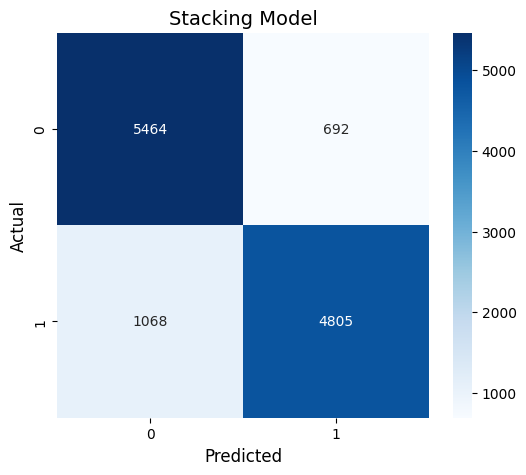

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the results on the test set
predictions = stacking_classifier.predict(x_test)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title('Stacking Model', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()

In [33]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Define base models
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=7, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=7, n_jobs=-1)),
    ('DecisionTree', DecisionTreeClassifier(max_depth=7, random_state=7))
]
# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=7)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.6f}")
print(f"Validation Accuracy: {accuracy_score(y_test, predictions):.6f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

Training Accuracy: 0.858624
Validation Accuracy: 0.853354
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6156
           1       0.87      0.82      0.84      5873

    accuracy                           0.85     12029
   macro avg       0.85      0.85      0.85     12029
weighted avg       0.85      0.85      0.85     12029



In [34]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Define base models
base_models = [
    ('Random_Forest', RandomForestClassifier(n_estimators=300, max_depth=None, random_state=123, n_jobs=-1)),
    ('ExtraTrees', ExtraTreesClassifier(n_estimators=550, max_depth=None, random_state=123, n_jobs=-1)),
    ('DecisionTree', DecisionTreeClassifier(max_depth=7, random_state=123))
]
# Instantiate the Logistic Regression model as the final estimator
lr_model = LogisticRegression(C=100, max_iter=100, penalty='l2', solver='liblinear', random_state=123)

# Instantiate the StackingClassifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=lr_model)

# Train the StackingClassifier on the training data
stacking_classifier.fit(x_train, y_train)

# Make predictions on the training data
y_train_pred = stacking_classifier.predict(x_train)

# Make predictions on the test data
predictions = stacking_classifier.predict(x_test)

# Print some results (e.g., accuracy)
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.6f}")
print(f"Validation Accuracy: {accuracy_score(y_test, predictions):.6f}")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, predictions))

Training Accuracy: 0.858749
Validation Accuracy: 0.853354
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      6156
           1       0.87      0.82      0.84      5873

    accuracy                           0.85     12029
   macro avg       0.86      0.85      0.85     12029
weighted avg       0.85      0.85      0.85     12029



**Simple Feedforward Neural Network**

Epoch 1/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7505 - loss: 0.5056 - val_accuracy: 0.8247 - val_loss: 0.3944
Epoch 2/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8226 - loss: 0.3920 - val_accuracy: 0.8302 - val_loss: 0.3795
Epoch 3/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8329 - loss: 0.3681 - val_accuracy: 0.8302 - val_loss: 0.3593
Epoch 4/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8368 - loss: 0.3535 - val_accuracy: 0.8399 - val_loss: 0.3425
Epoch 5/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8413 - loss: 0.3401 - val_accuracy: 0.8411 - val_loss: 0.3351
Epoch 6/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8454 - loss: 0.3308 - val_accuracy: 0.8417 - val_loss: 0.3287
Epoch 7/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8448 - loss: 0.3239 - val_accuracy: 0.8467 - val_loss: 0.3257
Epoch 8/32
482/482 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8471 - loss: 0.3191 - val_accuracy: 0.

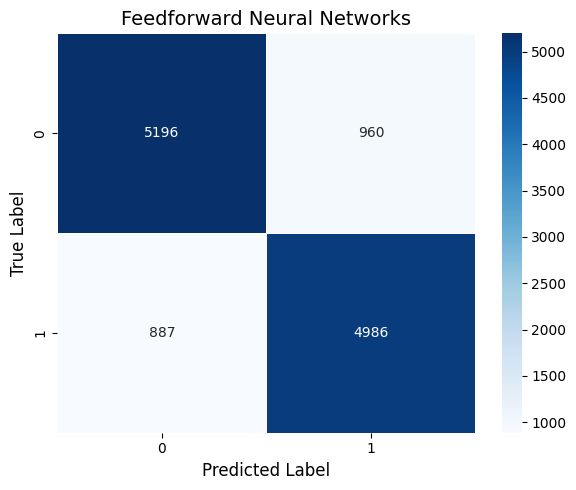


Length Check:
y_test: 12029
y_test_pred_ann: 12029


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical


# ======================================================
# 3. Convert labels to categorical for ANN ONLY
# ======================================================
y_train_cat = to_categorical(y_train)
y_test_cat  = to_categorical(y_test)

# ======================================================
# 4. ANN / Feedforward Neural Network Model
# ======================================================
model_simple = Sequential([
    Dense(64, input_shape=(x_train.shape[1],), activation="relu"),
    Dense(32, activation="relu"),
    Dense(2, activation="softmax")  # 2 output neurons for binary class
])

model_simple.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ======================================================
# 5. Train ANN
# ======================================================
history = model_simple.fit(
    x_train, y_train_cat,
    epochs=32,
    batch_size=100,
    validation_data=(x_test, y_test_cat),
    verbose=1
)

# ======================================================
# 6. Predictions (correct length guaranteed)
# ======================================================
# ANN predictions now correct
y_test_pred_ann = np.argmax(model_simple.predict(x_test), axis=1)
ann_accuracy = accuracy_score(y_test, y_test_pred_ann)

print(len(y_test), len(y_test_pred_ann))  # ✅ both 12029

# ======================================================
# 7. Accuracy
# ======================================================
ann_train_acc = accuracy_score(y_train, y_train_pred_ann)
ann_test_acc  = accuracy_score(y_test, y_test_pred_ann)

print(f"\n✅ ANN Training Accuracy:   {ann_train_acc:.4f}")
print(f"✅ ANN Validation Accuracy: {ann_test_acc:.4f}")

# ======================================================
# 8. Classification Report
# ======================================================
print("\n📌 ANN Classification Report:")
print(classification_report(y_test, y_test_pred_ann))

# ======================================================
# 9. Confusion Matrix (consistent formatting)
# ======================================================
cm = confusion_matrix(y_test, y_test_pred_ann)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],
    yticklabels=['0', '1'],
    linewidths=0.5
)
plt.title("Feedforward Neural Networks", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

# ======================================================
# 10. Sanity check — MUST MATCH
# ======================================================
print("\nLength Check:")
print("y_test:", len(y_test))
print("y_test_pred_ann:", len(y_test_pred_ann))


In [ ]:
print(len(y_test))
print(len(y_test_pred_ann))


12029
12029


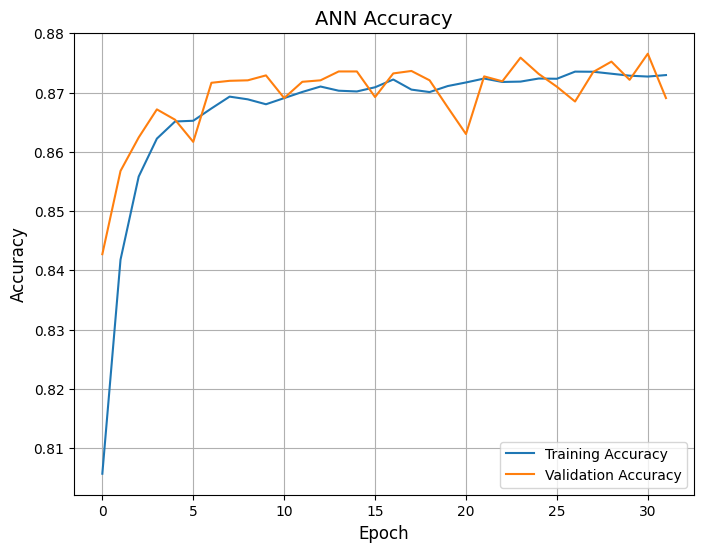

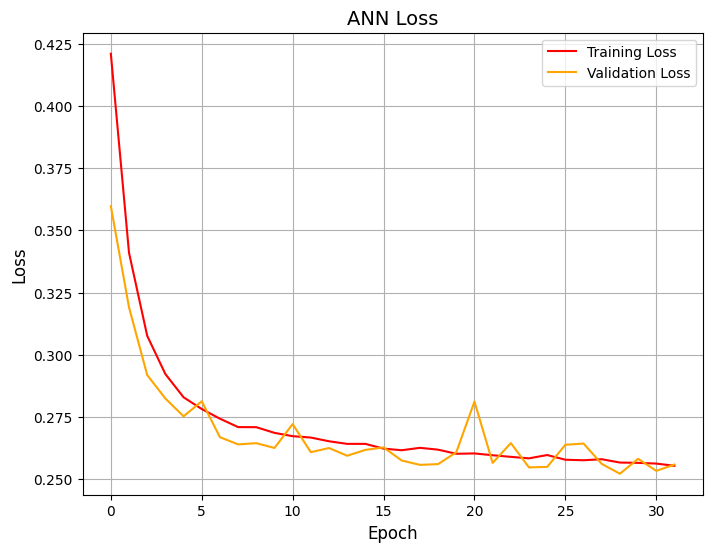

In [ ]:
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
simple_fwd_nn = model_simple.evaluate(x_test, y_test, verbose=0)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))  # Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))  # Loss plot
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('ANN Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()



### **CNN Model**

Epoch 1/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8003 - loss: 0.4285 - val_accuracy: 0.8041 - val_loss: 0.4191
Epoch 2/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8429 - loss: 0.3293 - val_accuracy: 0.8227 - val_loss: 0.3665
Epoch 3/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.8489 - loss: 0.3120 - val_accuracy: 0.8356 - val_loss: 0.3338
Epoch 4/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8496 - loss: 0.3052 - val_accuracy: 0.8501 - val_loss: 0.3020
Epoch 5/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.8507 - loss: 0.2995 - val_accuracy: 0.8513 - val_loss: 0.3020
Epoch 6/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8527 - loss: 0.2972 - val_accuracy: 0.8516 - val_loss: 0.3004
Epoch 7/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8556 - loss: 0.2948 - val_accuracy: 0.8516 - val_loss: 0.2973
Epoch 8/32
376/376 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.8526 - loss: 0.2986 - val_a

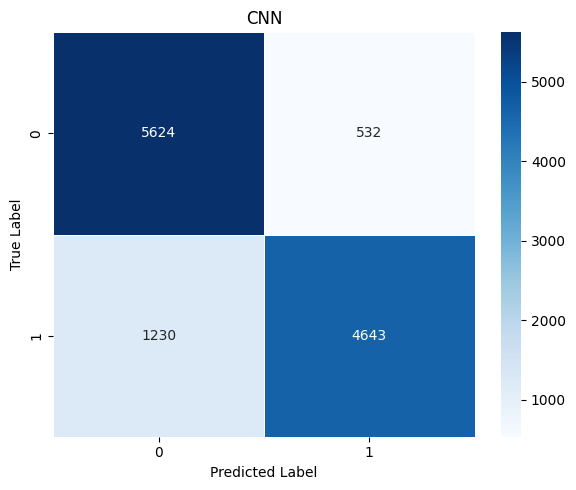

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# ==========================================================
# 1. One-hot encode categorical features
# ==========================================================
x_encoded = pd.get_dummies(x)   # x must be original feature DataFrame

# ==========================================================
# 2. Train-validation split (USED FOR ALL MODELS)
# ==========================================================
x_train, x_val, y_train, y_val = train_test_split(
    x_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# ==========================================================
# 3. Reshape for Conv1D input format
# Shape must be (samples, features, channels)
# ==========================================================
x_train = x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val   = x_val.values.reshape(x_val.shape[0], x_val.shape[1], 1)

# ==========================================================
# 4. Build CNN model for binary classification
# ==========================================================
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=2, padding='same', activation='relu',
           input_shape=(x_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=256, kernel_size=2, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')     # output neuron for binary classification
])

# ==========================================================
# 5. Compile model
# ==========================================================
optimizer = Adam(learning_rate=0.001)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# ==========================================================
# 6. Train the model
# ==========================================================
history = model_cnn.fit(
    x_train, y_train,
    epochs=32,
    batch_size=128,
    validation_data=(x_val, y_val),
    verbose=1
)

# ==========================================================
# 7. Predictions
# ==========================================================
y_val_pred = (model_cnn.predict(x_val) > 0.5).astype(int).ravel()
y_train_pred = (model_cnn.predict(x_train) > 0.5).astype(int).ravel()

# ==========================================================
# 8. Accuracy
# ==========================================================
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

print(f"\n✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}")

# ==========================================================
# 9. Classification Report
# ==========================================================
print("\n📌 Classification Report:")
print(classification_report(y_val, y_val_pred))

# ==========================================================
# 10. Confusion Matrix (consistent style)
# ==========================================================
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],
    yticklabels=['0', '1'],
    linewidths=0.5
)
plt.title("CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


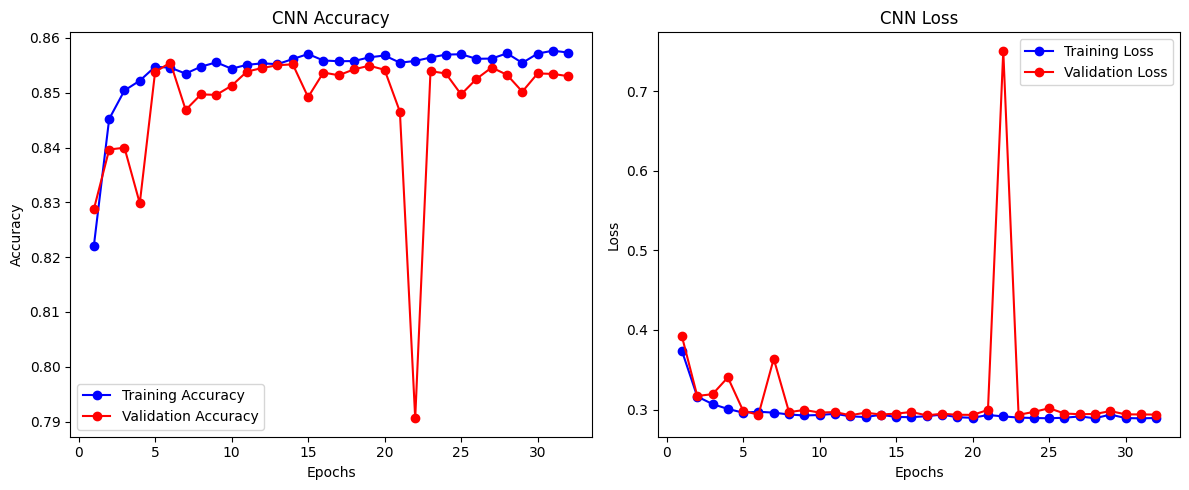

In [ ]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# **ML models**

In [ ]:
#Decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)

# Initialize the Decision Tree classifier with the best parameters
clf = DecisionTreeClassifier(
    random_state=42,
    criterion="entropy",
    max_depth=2,
    )

# Train the model
clf.fit(x_train, y_train)

# Predict on the training and validation sets
y_train_pred = clf.predict(x_train)
y_val_pred = clf.predict(x_val)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Display results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))



Training Accuracy: 0.8097
Validation Accuracy: 0.8140

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      6220
           1       0.82      0.78      0.80      5809

    accuracy                           0.81     12029
   macro avg       0.81      0.81      0.81     12029
weighted avg       0.81      0.81      0.81     12029



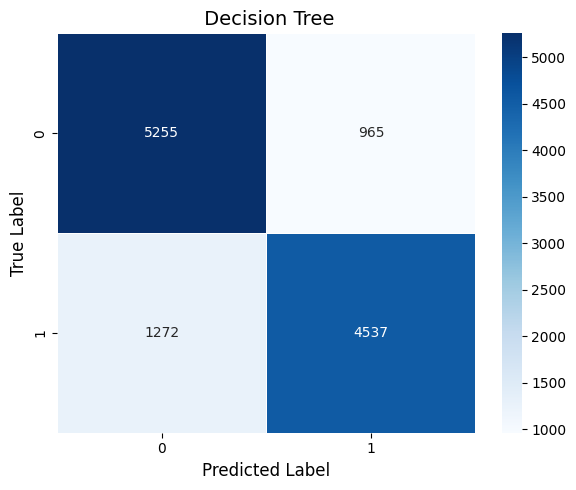

In [ ]:
# ✅ Confusion Matrix for Decision Tree
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],   # Change to class names if needed
    yticklabels=['0', '1'],
    linewidths=0.5
)

plt.title(" Decision Tree", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


**Random Forest**

Training accuracy (regularized Random Forest): 0.8264086629393304
Validation accuracy (regularized Random Forest): 0.827333942971153
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      6147
           1       0.86      0.78      0.81      5882

    accuracy                           0.83     12029
   macro avg       0.83      0.83      0.83     12029
weighted avg       0.83      0.83      0.83     12029



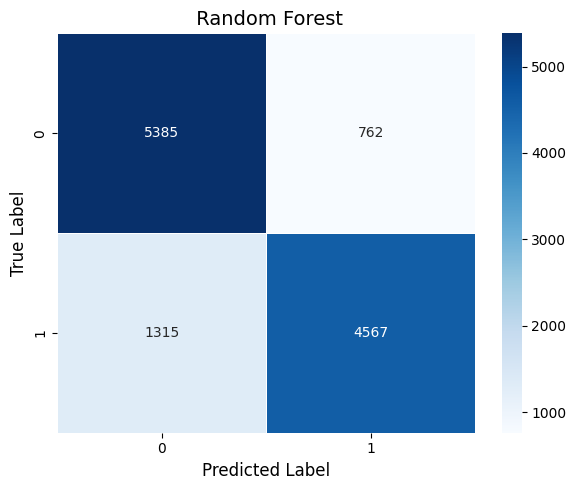

In [ ]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


# Initialize the Random Forest classifier with the best hyperparameters
best_rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', min_samples_split=5, min_samples_leaf=1, max_depth=20, bootstrap=True, random_state=42)

# Adjust min_impurity_decrease and bootstrap as needed
clf_regularized_rf = RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.01, bootstrap=True, random_state=42)

# Train the regularized Random Forest model on the training set
clf_regularized_rf.fit(x_train, y_train)

# Predict classes for training and validation sets
y_train_pred = clf_regularized_rf.predict(x_train)
y_val_pred = clf_regularized_rf.predict(x_val)

# Calculate accuracy for training and validation sets
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the results
print("Training accuracy (regularized Random Forest):", train_accuracy)
print("Validation accuracy (regularized Random Forest):", val_accuracy)

# Print classification report
print(classification_report(y_val, y_val_pred))

# ✅ Confusion Matrix for Regularized Random Forest
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],    # change to class names if desired
    yticklabels=['0', '1'],
    linewidths=0.5
)

plt.title(" Random Forest", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

seeds = [7, 123]
results = []

for seed in seeds:

    # Initialize RF with ONLY random_state changed
    rf_model = RandomForestClassifier(
        n_estimators=100,
        min_impurity_decrease=0.01,
        bootstrap=True,
        random_state=seed     # ← ONLY thing that varies
    )

    # Train
    rf_model.fit(x_train, y_train)

    # Predict on SAME x_test
    y_pred = rf_model.predict(x_test)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    results.append([seed, acc, prec, rec, f1])

# Convert to dataframe
df_rf = pd.DataFrame(results, columns=["Seed", "Accuracy", "Precision", "Recall", "F1"])

print("===== Random Forest Performance Across Seeds =====")
print(df_rf)
print("\n\n===== Summary Statistics =====")
print(df_rf.describe())


===== Random Forest Performance Across Seeds =====
   Seed      Accuracy     Precision        Recall            F1
0     7  0.8386399534  0.8916334661  0.7621317895  0.8218121730
1   123  0.8240917782  0.8429797334  0.7861399625  0.8135682819


===== Summary Statistics =====
                 Seed      Accuracy     Precision        Recall            F1
count    2.0000000000  2.0000000000  2.0000000000  2.0000000000  2.0000000000
mean    65.0000000000  0.8313658658  0.8673065998  0.7741358760  0.8176902274
std     82.0243866176  0.0102871134  0.0344033843  0.0169763419  0.0058293112
min      7.0000000000  0.8240917782  0.8429797334  0.7621317895  0.8135682819
25%     36.0000000000  0.8277288220  0.8551431666  0.7681338328  0.8156292547
50%     65.0000000000  0.8313658658  0.8673065998  0.7741358760  0.8176902274
75%     94.0000000000  0.8350029096  0.8794700330  0.7801379193  0.8197512002
max    123.0000000000  0.8386399534  0.8916334661  0.7861399625  0.8218121730


**Logistic Regression**

Training accuracy (Logistic Regression): 0.8192588281753372
Test accuracy (Logistic Regression): 0.8206833485742788

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      6147
           1       0.89      0.72      0.80      5882

    accuracy                           0.82     12029
   macro avg       0.83      0.82      0.82     12029
weighted avg       0.83      0.82      0.82     12029



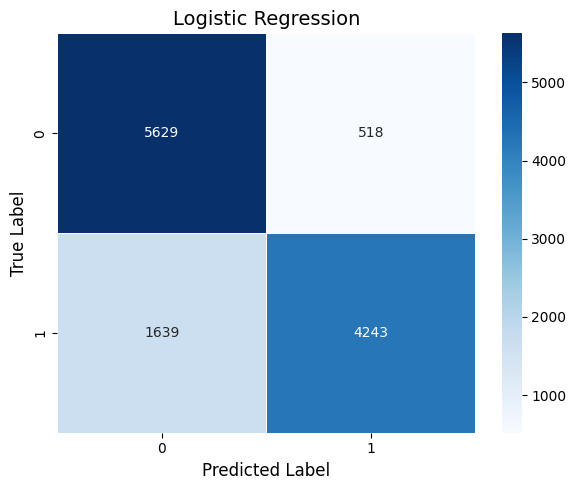

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Standardizing features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# ✅ Train model
logreg = LogisticRegression(max_iter=2000, penalty='l1', solver='saga')
logreg.fit(x_train_scaled, y_train)

# ✅ Predictions
y_pred = logreg.predict(x_test_scaled)

# ✅ Fix y_test if one-hot encoded
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# ✅ Accuracy
train_accuracy = accuracy_score(y_train, logreg.predict(x_train_scaled))
test_accuracy = accuracy_score(y_test, y_pred)

print("Training accuracy (Logistic Regression):", train_accuracy)
print("Test accuracy (Logistic Regression):", test_accuracy)

# ✅ Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ✅ Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],
    yticklabels=['0', '1'],
    linewidths=0.5
)
plt.title("Logistic Regression", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


**XGBoost**

Training Accuracy: 86.25%
Validation Accuracy: 85.53%

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6147
           1       0.89      0.80      0.84      5882

    accuracy                           0.86     12029
   macro avg       0.86      0.85      0.85     12029
weighted avg       0.86      0.86      0.85     12029



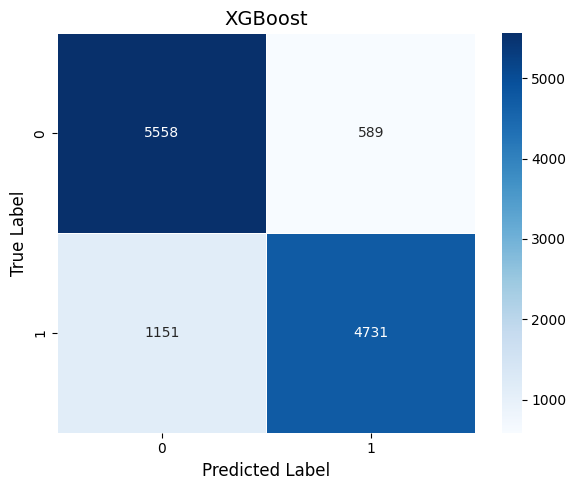

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming your data is already loaded in X and y
# Split the dataset into training and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Step 1: Initialize the XGBoost model
xg_model = xgb.XGBClassifier(random_state=42,  objective='binary:logistic')

# Step 2: Train the model
xg_model.fit(x_train, y_train)

# Step 3: Make predictions on both training and test (validation) data
y_train_pred = xg_model.predict(x_train)
y_test_pred = xg_model.predict(x_test)

# Step 4: Calculate training and validation accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Step 5: Display accuracy and classification report
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot in consistent style
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['0', '1'],
    yticklabels=['0', '1'],
    linewidths=0.5
)

plt.title("XGBoost", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Seeds to evaluate
seeds = [7, 123]

results = []

for seed in seeds:

    # Initialize XGBoost with only random_state changed
    xg_model = xgb.XGBClassifier(
        random_state=seed,
        objective='binary:logistic',
        eval_metric='logloss'
    )

    # Train on SAME x_train
    xg_model.fit(x_train, y_train)

    # Predict on SAME x_test
    y_pred = xg_model.predict(x_test)

    # Metrics
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    results.append([seed, acc, prec, rec, f1])

# Convert to dataframe
df_xg = pd.DataFrame(results, columns=["Seed", "Accuracy", "Precision", "Recall", "F1"])

print("===== XGBoost Performance Across Seeds =====")
print(df_xg)
print("\n===== Summary Statistics =====")
print(df_xg.describe())


===== XGBoost Performance Across Seeds =====
   Seed      Accuracy     Precision        Recall            F1
0     7  0.8577604123  0.8842319055  0.8154265282  0.8484365311
1   123  0.8577604123  0.8842319055  0.8154265282  0.8484365311

===== Summary Statistics =====
                 Seed      Accuracy     Precision        Recall            F1
count    2.0000000000  2.0000000000  2.0000000000  2.0000000000  2.0000000000
mean    65.0000000000  0.8577604123  0.8842319055  0.8154265282  0.8484365311
std     82.0243866176  0.0000000000  0.0000000000  0.0000000000  0.0000000000
min      7.0000000000  0.8577604123  0.8842319055  0.8154265282  0.8484365311
25%     36.0000000000  0.8577604123  0.8842319055  0.8154265282  0.8484365311
50%     65.0000000000  0.8577604123  0.8842319055  0.8154265282  0.8484365311
75%     94.0000000000  0.8577604123  0.8842319055  0.8154265282  0.8484365311
max    123.0000000000  0.8577604123  0.8842319055  0.8154265282  0.8484365311


# **95% Confidence Interval**

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats

stack_acc  = [0.86, 0.86, 0.860005]
stack_prec = [0.86, 0.86, 0.86]
stack_rec  = [0.89, 0.89, 0.89]   # class 0 recall is 0.89
stack_f1   = [0.87, 0.87, 0.87]
rf_acc  = [0.83681104, 0.83373514, 0.82409178]
rf_prec = [0.88774296, 0.87,       0.84297973]
rf_rec  = [0.76213179, 0.78,       0.78613996]
rf_f1   = [0.82015575, 0.83,       0.81356828]
xg_acc  = [0.85776041, 0.8553, 0.85776041]
xg_prec = [0.88423191, 0.89,   0.88423191]
xg_rec  = [0.81542653, 0.80,   0.81542653]
xg_f1   = [0.84843653, 0.84,   0.84843653]

# -----------------------------
# CI function
# -----------------------------
def compute_ci(values):
    arr = np.array(values, dtype=float)
    mean = np.mean(arr)
    sd   = np.std(arr, ddof=1)
    n    = len(arr)
    t_crit = stats.t.ppf(0.975, df=n-1)
    ci_low  = mean - t_crit * sd / np.sqrt(n)
    ci_high = mean + t_crit * sd / np.sqrt(n)
    return mean, sd, ci_low, ci_high

# -----------------------------
# Put your metric lists here
# -----------------------------
models = {
    "Stacking": {
        "Accuracy":  stack_acc,
        "Precision": stack_prec,
        "Recall":    stack_rec,
        "F1":        stack_f1
    },
    "Random Forest": {
        "Accuracy":  rf_acc,
        "Precision": rf_prec,
        "Recall":    rf_rec,
        "F1":        rf_f1
    },
    "XGBoost": {
        "Accuracy":  xg_acc,
        "Precision": xg_prec,
        "Recall":    xg_rec,
        "F1":        xg_f1
    }
}

# -----------------------------
# Build CI Table
# -----------------------------
rows = []

for model_name, metrics in models.items():
    row = {"Model": model_name}
    for metric_name, values in metrics.items():
        mean, sd, low, high = compute_ci(values)
        row[f"{metric_name}_Mean"] = mean
        row[f"{metric_name}_SD"] = sd
        row[f"{metric_name}_CI_Lower"] = low
        row[f"{metric_name}_CI_Upper"] = high
    rows.append(row)

df_ci = pd.DataFrame(rows)
print(df_ci)


           Model  Accuracy_Mean   Accuracy_SD  Accuracy_CI_Lower  \
0       Stacking   0.8600016667  0.0000028868       0.8599944956   
1  Random Forest   0.8315459867  0.0066362028       0.8150607450   
2        XGBoost   0.8569402733  0.0014205184       0.8534115101   

   Accuracy_CI_Upper  Precision_Mean  Precision_SD  Precision_CI_Lower  \
0       0.8600088378    0.8600000000  0.0000000000        0.8600000000   
1       0.8480312284    0.8669075633  0.0225412747        0.8109119329   
2       0.8604690366    0.8861546067  0.0033302083        0.8778819106   

   Precision_CI_Upper   Recall_Mean     Recall_SD  Recall_CI_Lower  \
0        0.8600000000  0.8900000000  0.0000000000     0.8900000000   
1        0.9229031938  0.7760905833  0.0124723980     0.7451074292   
2        0.8944273027  0.8102843533  0.0089065112     0.7881593529   

   Recall_CI_Upper       F1_Mean         F1_SD   F1_CI_Lower   F1_CI_Upper  
0     0.8900000000  0.8700000000  0.0000000000  0.8700000000  0.87000000

# **McNemar’s test**

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np

y_true = y_test.values

# --- Assign predictions ---
pred_stack = pred          # stacking
pred_xg    = y_pred        # xgboost
pred_rf    = pred_rf       # random forest (from above)

def run_mcnemar(model1_name, m1, model2_name, m2, y_true):
    b01 = np.sum((m1 == y_true) & (m2 != y_true))
    b10 = np.sum((m1 != y_true) & (m2 == y_true))

    table = [[0, b01],
             [b10, 0]]

    result = mcnemar(table, exact=False, correction=True)

    print(f"\n===== McNemar Test: {model1_name} vs {model2_name} =====")
    print(f"b01 = {b01}, b10 = {b10}")
    print(f"Test statistic: {result.statistic}")
    print(f"p-value: {result.pvalue}")

    if result.pvalue < 0.05:
        print("➡ Significant difference (p < 0.05)")
    else:
        print("➡ No significant difference (p ≥ 0.05)")


# Run all pairwise comparisons
run_mcnemar("Stacking", pred_stack, "Random Forest", pred_rf, y_true)
run_mcnemar("Stacking", pred_stack, "XGBoost", pred_xg, y_true)
run_mcnemar("Random Forest", pred_rf, "XGBoost", pred_xg, y_true)



===== McNemar Test: Stacking vs Random Forest =====
b01 = 571, b10 = 227
Test statistic: 147.4298245614035
p-value: 6.320775067901523e-34
➡ Significant difference (p < 0.05)

===== McNemar Test: Stacking vs XGBoost =====
b01 = 636, b10 = 227
Test statistic: 192.8899188876014
p-value: 7.439582243415618e-44
➡ Significant difference (p < 0.05)

===== McNemar Test: Random Forest vs XGBoost =====
b01 = 65, b10 = 0
Test statistic: 63.01538461538462
p-value: 2.0509832838431065e-15
➡ Significant difference (p < 0.05)


In [ ]:
g = dict(globals())   # snapshot → prevents RuntimeError

for name, val in g.items():
    try:
        if hasattr(val, "__len__") and len(val) == len(y_test):
            print(f"{name:25}  type={type(val)}")
    except:
        pass


x_test                     type=<class 'pandas.core.frame.DataFrame'>
y_test                     type=<class 'pandas.core.series.Series'>
pred                       type=<class 'numpy.ndarray'>
y_pred                     type=<class 'numpy.ndarray'>
x_test_cnn                 type=<class 'numpy.ndarray'>
y_true                     type=<class 'numpy.ndarray'>


# **TabNet**

In [ ]:
pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00


epoch 0  | loss: 0.4933  | val_0_accuracy: 0.81087 |  0:00:16s
epoch 10 | loss: 0.31726 | val_0_accuracy: 0.85252 |  0:02:00s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_accuracy = 0.85535
TabNet Test Accuracy: 0.8553495718679857

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6156
           1       0.89      0.81      0.84      5873

    accuracy                           0.86     12029
   macro avg       0.86      0.85      0.85     12029
weighted avg       0.86      0.86      0.85     12029



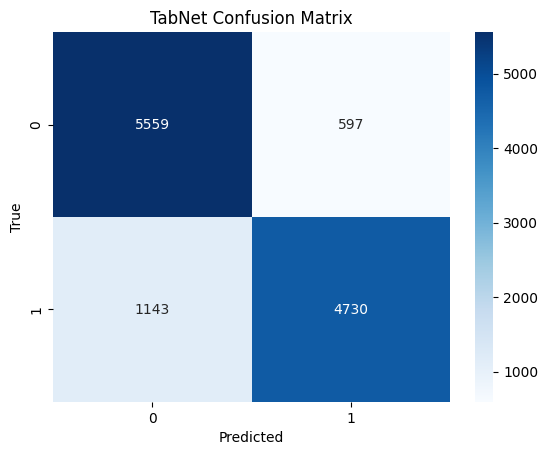

In [ ]:
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch

import numpy as np

X_train_tab = np.array(x_train, dtype=np.float32)
X_test_tab  = np.array(x_test, dtype=np.float32)
y_train_tab = np.array(y_train, dtype=np.int64)
y_test_tab  = np.array(y_test, dtype=np.int64)

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

tabnet = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='entmax',
    seed=42,
    verbose=10
)

tabnet.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_tab = tabnet.predict(X_test_tab)

print("TabNet Test Accuracy:", accuracy_score(y_test_tab, y_pred_tab))
print("\nClassification Report:")
print(classification_report(y_test_tab, y_pred_tab))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_tab, y_pred_tab)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TabNet Confusion Matrix")
plt.show()
